# Section 0 (optional)
### The provided data is a small subset of possible gate types and other gates might have different features/colors.
### To account for this issue a quick web scraping will help to grow the versatility in the dataset.

In [1]:
# !pip install --upgrade simple-image-download==0.4

#### 1. Download 500 samples. Location "./data/simple_images"

In [2]:
# from simple_image_download import simple_image_download as sp

# response = sp.simple_image_download

# response().download(keywords = "subway station ticket barrier gates", limit = 500)

#### 2. After downloading 500 images the "utils/duplicate_image_finder.py" script is used to remove ~400 duplicates.
#### 3. A manual visual clean up was done to remove bad samples.
#### 4. The individual instances of gates were cropped out of the bigger images.
#### 5. The cropped images were split into "open" and "closed" folders.
#### 6. Then the images were renamed according to their folders with the following naming convention: "ws_XXXX_1.jpg".
#### 7. The new images were combined with the existing dataset received from Glimpse Analytics Ltd.

## 8. Before applying any transformations, split the dataset into train and val.
#### The dataset was split to train, val and test sets with a 0.7 - 0.2 - 0.1 ratio respectively. To do this, the "utils/train-val-test_split.py"  helper script was used.

# Section 1
## Data augmentation

In [3]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

plt.rcParams["savefig.bbox"] = 'tight'

<function matplotlib.pyplot.show(close=None, block=None)>

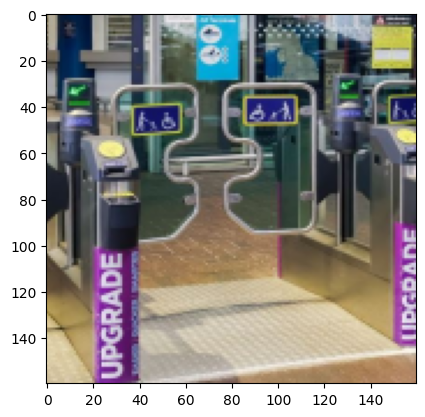

In [4]:
# Viewing a sample image 
image_path = r"./data/all_raw_imgs/train/closed/ws_closed_48.jpg"
image = cv2.imread(image_path, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resizing an image
image = cv2.resize(image, (160, 160), interpolation = cv2.INTER_AREA)

plt.imshow(image)
plt.show

In [5]:
import os
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

torch.manual_seed(0)

### Get the mean and standard deviation of the images in the training dataset.
#### Update note: I ended up not using normalisation since for some reason it hurt the final model performance.

In [6]:
training_transforms = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor()
    ])

train_dataset_path = './data/all_raw_imgs/train'
print(os.listdir(train_dataset_path))

train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=training_transforms)
train_loader  = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)

['closed', 'open']


In [7]:
def get_mean_and_std(loader):
    mean= 0.
    std = 0.
    total_images_count = 0
    
    for images, labels in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)        
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    

    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

train_mean, train_std = get_mean_and_std(train_loader)
print('RGB Mean:',train_mean)
print('RGB Std :', train_std)

RGB Mean: tensor([0.4283, 0.4232, 0.4222])
RGB Std : tensor([0.1982, 0.1997, 0.1998])


### Dataset preparation

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(160,160)),
    transforms.ColorJitter(brightness=(0.8,1.5), contrast = 0.25 ,saturation = 0.25, hue=0.25),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
#     transforms.Normalize(mean=train_mean, std=train_std)
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(160,160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
#     transforms.Normalize(mean=train_mean, std=train_std)
])

In [9]:
train_dataset_path = './data/all_raw_imgs/train'
val_dataset_path = './data/all_raw_imgs/val'

train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset   = torchvision.datasets.ImageFolder(root = val_dataset_path, transform = val_transforms)

#### Storing transformed images
In this case, instead of instantiating loaders I will save the transformed images in folders to use with YOLOv8.

In [10]:
# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True)
# val_loader = torch.utils.data.DataLoader(dataset   = val_dataset  , batch_size=32, shuffle=False)

labels:  tensor([1, 0, 0, 0, 0, 0])


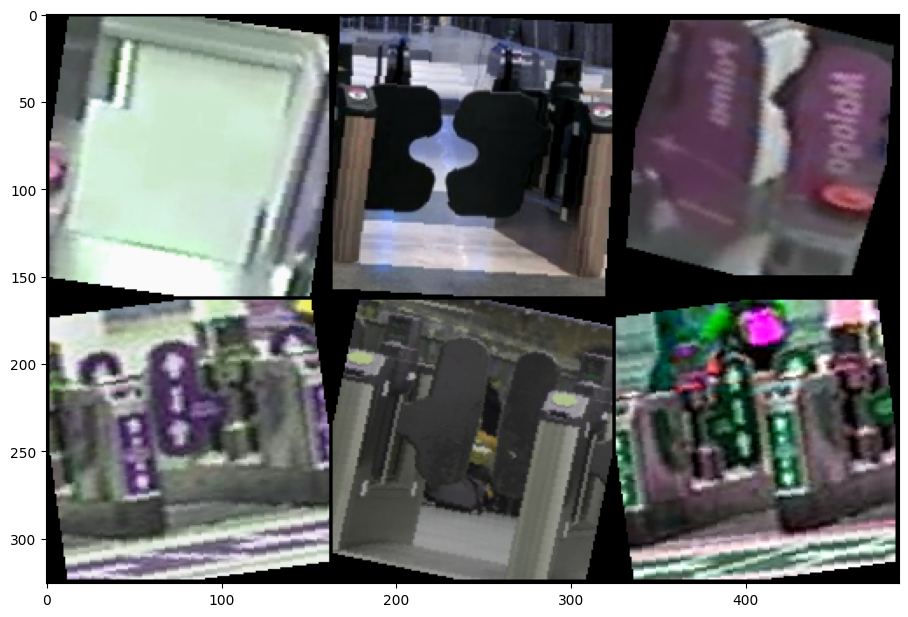

In [11]:
def show_transformed_images(dataset):
    loader =  torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

show_transformed_images(train_dataset)

### Generate a dataset of transformed images.

In [12]:
# Create the dataset directory tree in YOLO format
root_dir_name = 'transformed_images'
os.mkdir(f'./data/{root_dir_name}')
os.mkdir(f'./data/{root_dir_name}/train')
os.mkdir(f'./data/{root_dir_name}/train/open')
os.mkdir(f'./data/{root_dir_name}/train/closed')
os.mkdir(f'./data/{root_dir_name}/val')
os.mkdir(f'./data/{root_dir_name}/val/open')
os.mkdir(f'./data/{root_dir_name}/val/closed')

In [13]:
index_closed = 0
index_open = 0
for _ in range(10):
    for img, label in train_dataset:
        if label == 0:
            save_image(img, f'data/{root_dir_name}/train/closed/closed_{index_closed}.jpg')
            index_closed += 1
        elif label == 1:
            save_image(img, f'data/{root_dir_name}/train/open/open_{index_open}.jpg')
            index_open += 1

In [14]:
index_closed = 0
index_open = 0
for _ in range(10):
    for img, label in val_dataset:
        if label == 0:
            save_image(img, f'data/{root_dir_name}/val/closed/closed_{index_closed}.jpg')
            index_closed += 1
        elif label == 1:
            save_image(img, f'data/{root_dir_name}/val/open/open_{index_open}.jpg')
            index_open += 1

# Section 2
## Training a Yolov8x classification model by Ultralytics

In [15]:
# ! pip install ultralytics==8.0.58

In [16]:
import pandas as pd
from ultralytics import YOLO

In [21]:
# # Set up Tensorboard
# %load_ext tensorboard
# %tensorboard --logdir runs/classify/train18'

In [22]:
# Load a model
model = YOLO('yolov8x-cls.pt')  # load a pretrained model (recommended for training)

In [23]:
# Train the model
results = model.train(data='E:/Glimpse_analytics/data/transformed_images', epochs=25, imgsz=160)

New https://pypi.org/project/ultralytics/8.0.209 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.58  Python-3.11.5 torch-2.1.0+cpu CPU
yolo\engine\trainer: task=classify, mode=train, model=yolov8x-cls.pt, data=E:/Glimpse_analytics/data/transformed_images5, epochs=25, patience=50, batch=16, imgsz=160, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it]
                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size
      17/25         0G   0.001758          2        160: 100%|██████████| 134/134 [07:29<00:00,  3.35s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]
                   all      0.905          1

      Epoch    GPU_mem       loss  Instances       Size
      18/25         0G  0.0007822          2        160: 100%|██████████| 134/134 [07:27<00:00,  3.34s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:37<00:00,  3.76s/it]
                   all      0.903          1

      Epoch    GPU_mem       loss  Instances       Size
      19/25         0G   0.000441          2        160: 100%|██████████| 134/134 [07:30<00:00,  3.36s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:37<00:00,  3.72s/i

In [17]:
# results = model.val()

Ultralytics YOLOv8.0.58  Python-3.11.5 torch-2.1.0+cpu CPU
               classes   top1_acc   top5_acc: 100%|██████████| 39/39 [00:41<00:00,  1.07s/it]
                   all      0.962          1
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val


## Visualise losses and accuracy

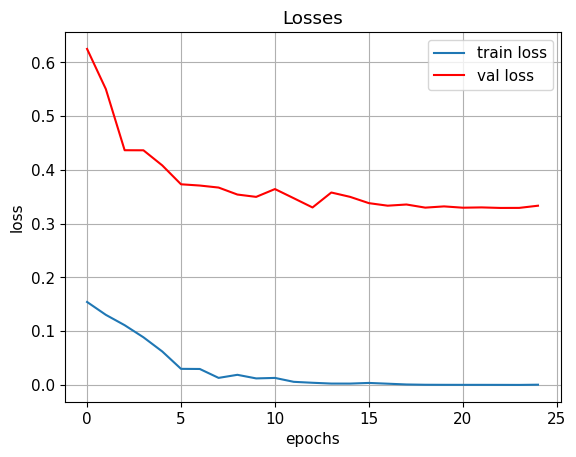

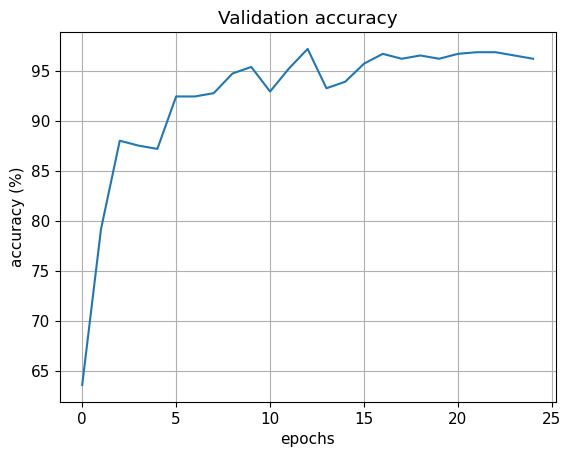

In [32]:
%matplotlib inline

results_path = './results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Losses')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()


### Test the resulting model

labels:  tensor([0, 1, 1, 0, 0, 1])


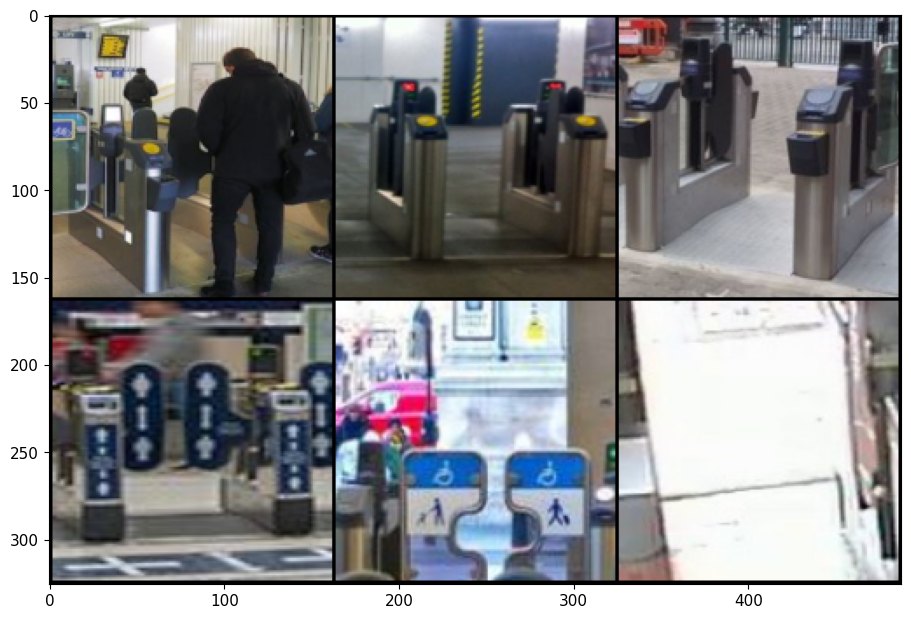

In [18]:
test_dataset_path = './data/all_raw_imgs/test'

test_transforms = transforms.Compose([
    transforms.Resize(size=(160,160)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=train_mean, std=train_std)
])

test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
show_transformed_images(test_dataset)

In [33]:
from sklearn.metrics import f1_score, accuracy_score

# Load the model
model = YOLO('./yolov8x_cls_custom.pt')

y_true = []
y_pred = []

# Run inference and print predictions
for imgs, label in test_loader:
    
    results = model(imgs, verbose=False)
    cls_names = results[0].names
    probabilities = results[0].probs.tolist()
    
    y_true.append(label.item())
    y_pred.append(np.argmax(results[0].probs.tolist()))
    
    print(
            "label:", f'{cls_names[label.item()]:6}',
        
            ",  prediction:", f'{cls_names[np.argmax(results[0].probs.tolist())]:6}',
        
            ",  confidence:", round(max(probabilities),3)
         )

label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 0.995
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 0.602
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label: closed ,  prediction: closed ,  confidence: 1.0
label:

## Accuracy and F1-score

As you can see the model performance is good, but the reason both F1-score and Accuracy are strictly 1 only because the test set is not large.

In [34]:
print('F1-score:', f1_score(y_trues, y_preds))
print('Accuracy:', accuracy_score(y_trues, y_preds))

F1-score: 1.0
Accuracy: 1.0


# Conclusions

As it can be seen from the diagrams above, the model reached a reasonably high accuracy rate on the validation dataset. Loss values on the training dataset converged at near-zero, suggesting a low bias in the model. However, judging from the gap between the convergence lines of training loss and validation loss the prediciton accuracy could be improved by removing some of the error caused by variance. I tried to introduce this imrovement by growing the dataset through web scraping, but it seems there is still room for improvement if larger, domain specific datasets are provided, represeanting the actual underlying distibutions, i.e. images from actual CCTV cameras.

# Future work

Another step for improving model performance could be using libraries to synthetically generate data. I was intending to do that with a Github library called ***flip*** by ***LinkedAI***. I have used it before to generate a large image dataset with a lot of variability from a small number of seed images. In my case it was for generating a dataset of printed circuit boards with implanted anomalies *(extra computer chips)*.

In the scope of the current *open/closed gate* project, I was planning to use this library to superimpose images of walking people with the images of the gates. This would have artificially placed ***.png*** images of walking people with transparent backgrounds in front of the open/closed gate images we had. This would be a step up in introducing variability in the training dataset, compared to web scraping and image augmentation techniques implemented in this Jupyter notebook.

That said, it would have been a D-tour from the assigned task, the model already had a reasonable performance and I would not have had sufficient time to *(properly)* implement it on this project.